# IRAS 16562-3959 Euclidean Minimum Spanning Tree

In [1]:
# Parts of the code were adapted from Jake VanderPlas entry on AstroML
# http://www.astroml.org/book_figures/chapter6/fig_great_wall_MST.html

# Importing libraries
import numpy as np
from matplotlib import pyplot as plt

from scipy import sparse
from sklearn.mixture import GMM

from astroML.clustering import HierarchicalClustering, get_graph_segments
import warnings

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

warnings.filterwarnings("ignore")

In [2]:
# get data
X = np.loadtxt('All_protostars_with_unclass_Xray_physical_coordinates.txt')

xmin, xmax = (-8, 8)
ymin, ymax = (-8, 8)


In [3]:
# Compute the MST clustering model
#
#    Parameters
#    ----------
#    n_neighbors : int
#      number of neighbors of each point used for approximate Euclidean
#      minimum spanning tree (MST) algorithm.  See Notes below.
#        Notes
#        -----
#            This routine uses an approximate Euclidean minimum spanning tree (MST)
#            to perform hierarchical clustering.  A true Euclidean minimum spanning
#            tree naively costs O[N^3].  Graph traversal algorithms only help so much,
#            because all N^2 edges must be used as candidates.  In this approximate
#            algorithm, we use k < N edges from each point, so that the cost is only
#            O[Nk log(Nk)]. For k = N, the approximation is exact; in practice for
#            well-behaved data sets, the result is exact for k << N.
#
#    edge_cutoff : float
#        specify a fraction of edges to keep when selecting clusters.
#        edge_cutoff should be between 0 and 1.
#    min_cluster_size : int, optional
#        specify a minimum number of points per cluster.  If not specified,
#        all clusters will be kept.
#
#    Attributes
#    ----------
#    X_train_ : ndarray
#        the training data
#    full_tree_ : sparse graph
#        the full approximate Euclidean MST spanning the data
#    cluster_graph_ : sparse graph
#        the final (truncated) graph showing clusters
#    n_components_ : int
#        the number of clusters found.
#    labels_ : int
#        the cluster labels for each training point.  Labels range from -1
#        to n_components_ - 1: points labeled -1 are in the background (i.e.
#        their clusters were smaller than min_cluster_size)


n_neighbors = 2
edge_cutoff = 0.9
cluster_cutoff = 20
model = HierarchicalClustering(n_neighbors=n_neighbors,
                               edge_cutoff=edge_cutoff,
                               min_cluster_size=cluster_cutoff)
model.fit(X)
print(" scale: %2g pc" % np.percentile(model.full_tree_.data,
                                        100 * edge_cutoff))

n_components = model.n_components_
labels = model.labels_

#        After fit() is called, this method may be called to obtain a
#        clustering result with a new edge_cutoff and min_cluster_size.
#        Parameters
#        ----------
#        edge_cutoff : float, optional
#            specify a fraction of edges to keep when selecting clusters.
#            edge_cutoff should be between 0 and 1.  If not specified,
#            self.edge_cutoff will be used.
#        min_cluster_size : int, optional
#            specify a minimum number of points per cluster.  If not specified,
#            self.min_cluster_size will be used.
#        Returns
#        -------
#        n_components : int
#            the number of clusters found
#        labels : ndarray
#            the labels of each point.  Labels range from -1 to
#            n_components_ - 1: points labeled -1 are in the background
#            (i.e. their clusters were smaller than min_cluster_size)
#        T_trunc : sparse matrix
#            the truncated minimum spanning tree

 scale: 0.449644 pc


In [4]:
# Get the x, y coordinates of the beginning and end of each line segment
#    """Get graph segments for plotting a 2D graph
#    Parameters
#    ----------
#    X : array_like
#        the data, of shape [n_samples, 2]
#    G : array_like or sparse graph
#        the [n_samples, n_samples] matrix encoding the graph of connectinons
#        on X
#    Returns
#    -------
#    x_coords, y_coords : ndarrays
#        the x and y coordinates for plotting the graph.  They are of size
#        [2, n_links], and can be visualized using
#        ``plt.plot(x_coords, y_coords, '-k')``

T_x, T_y = get_graph_segments(model.X_train_,
                              model.full_tree_)
T_trunc_x, T_trunc_y = get_graph_segments(model.X_train_,
                                          model.cluster_graph_)

In [5]:
# Fit a GMM to each individual cluster ()General Method of Moments?)
Nx = 200
Ny = 200
Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                            np.linspace(ymin, ymax, Ny)))).T
density = np.zeros(Xgrid.shape[0])

for i in range(n_components):
    ind = (labels == i)
    Npts = ind.sum()
    Nclusters = min(12, Npts // 5)

    gmm = GMM(Nclusters).fit(X[ind])
    dens = np.exp(gmm.score(Xgrid))
    density += dens / dens.max()

density = density.reshape((Ny, Nx))

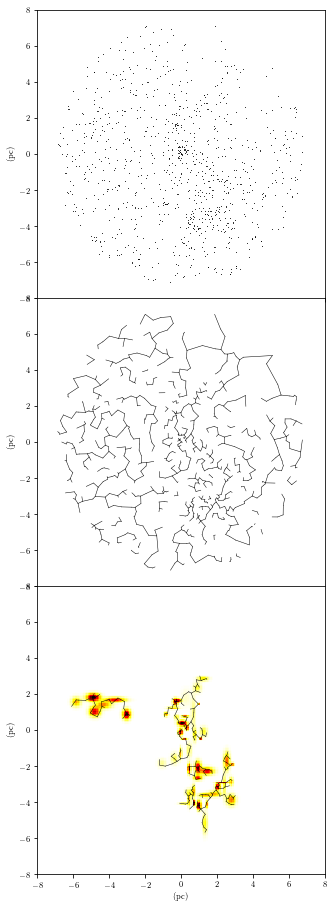

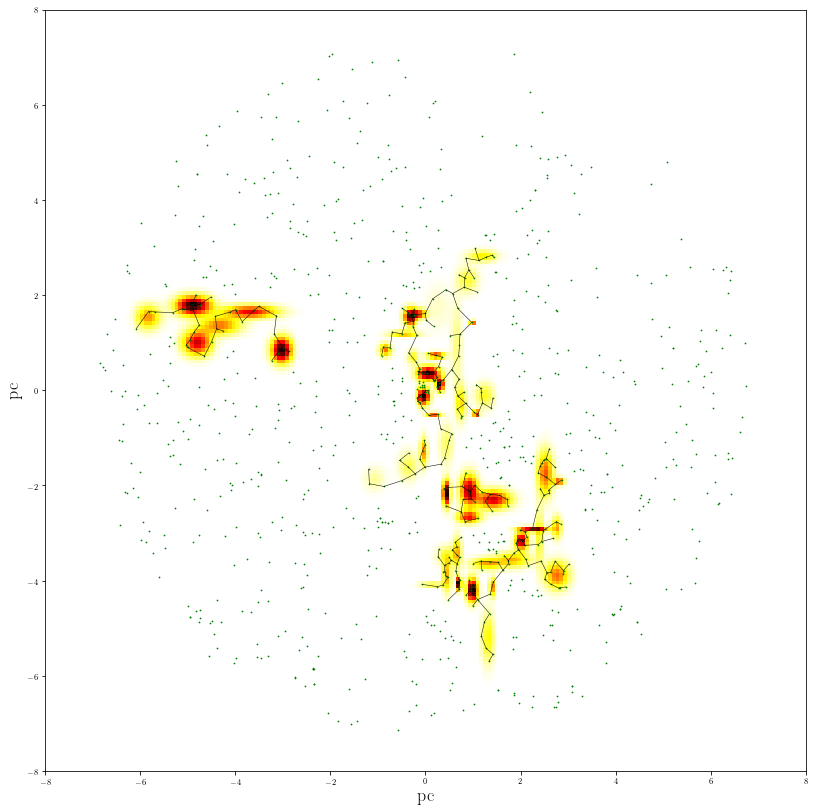

In [6]:
# Plot the results
fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(hspace=0, left=0.1, right=0.95, bottom=0.1, top=0.9)

ax = fig.add_subplot(311, aspect='equal')
ax.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')
ax.set_xlim(ymin, ymax)
ax.set_ylim(xmin, xmax)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylabel('(pc)')

ax = fig.add_subplot(312, aspect='equal')
ax.plot(T_y, T_x, c='k', lw=0.5)
ax.set_xlim(ymin, ymax)
ax.set_ylim(xmin, xmax)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylabel('(pc)')

ax = fig.add_subplot(313, aspect='equal')
ax.plot(T_trunc_y, T_trunc_x, c='k', lw=0.5)
ax.imshow(density.T, origin='lower', cmap=plt.cm.hot_r,
          extent=[ymin, ymax, xmin, xmax])

ax.set_xlim(ymin, ymax)
ax.set_ylim(xmin, xmax)
ax.set_xlabel('(pc)')
ax.set_ylabel('(pc)')


fig2 = plt.figure(2, figsize=(14,14))
ax2 = fig2.add_subplot(111)
ax2.plot(T_trunc_y, T_trunc_x, c='k', lw=0.5)
ax2.imshow(density.T, origin='lower', cmap=plt.cm.hot_r,
          extent=[ymin, ymax, xmin, xmax])
ax2.scatter(X[:, 1], X[:, 0], s=3, lw=0, c='g')
ax2.set_xlabel('pc', fontsize=18)
ax2.set_ylabel('pc', fontsize=18)


plt.show()
